In this notebook we use a bit of Python code to play around with models of Brownian motion.
This is meant to complement Section 3.2 on Brownian motion from Luke Harmon's
[book on comparative methods](https://lukejharmon.github.io/pcm/chapters/).

First, let's import the Python modules we will be using:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.stats import norm

_RNG = np.random.default_rng()

plt.rcParams['figure.figsize'] = [9.5, 6]

Next, let's define a function that will evolve a continuous trait through time according to Brownian motion. The basic idea is to take steps through time and simulate the change in the value of the trait by drawing a random number from a normal distribution with a mean of 0 and variance equal to the rate of evolution times the duration of the time step (i.e., trait change = normal(mean = 0, variance = rate * change in time)).

In [2]:
def sim_brownian_motion(
        time = 10.0,
        rate = 1.0,
        starting_value = 0.0,
        time_step_size = 0.1,
        rng = _RNG):
    # Make sure our time steps are not larger than the total time duration
    assert time_step_size <= time
    # Create vectors for storing the times at which we sample the evolving
    # trait, and the trait values themselves
    time_points = [0.0]
    trait_values = [starting_value]
    # Define our starting values and then step through the total time
    # one `time_step_size` at a time
    current_time = 0.0
    current_trait_value = starting_value
    while current_time < time:
        time_step = time_step_size
        # Make sure this step doesn't overshoot the end time
        if (current_time + time_step >= time):
            time_step = time - current_time
        variance = rate * time_step
        std_dev = math.sqrt(variance)
        # The change in the trait value is always distributed as
        # normal(0, variance = rate * time)
        trait_change = rng.normal(0, std_dev)
        current_trait_value += trait_change
        trait_values.append(current_trait_value)
        current_time += time_step
        time_points.append(current_time)
    return trait_values, time_points

Let's test out our Brownian motion function by simulating a trait for 50 time units, sampling its value every 0.1 time units:

Text(0, 0.5, 'Trait value')

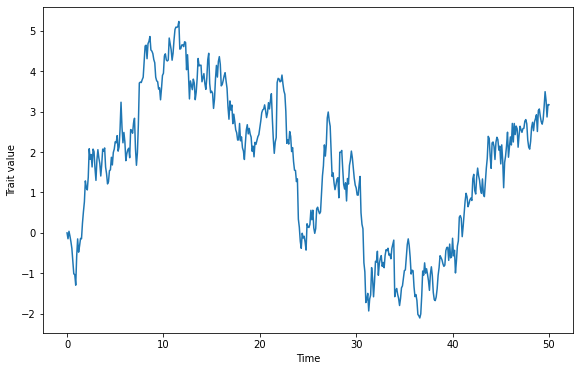

In [3]:
trait_vals, time_points = sim_brownian_motion(time = 50.0)
plt.plot(time_points, trait_vals)
plt.xlabel("Time")
plt.ylabel("Trait value")

Now, let's do that 100 times and look at the variation we see across our simulation replicates:

Text(0, 0.5, 'Trait value')

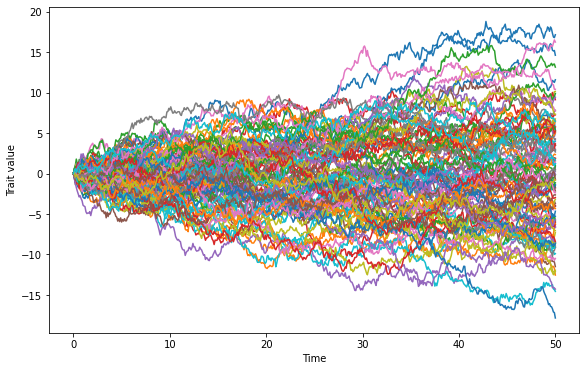

In [4]:
trait_vals_at_end = []
for i in range(100):
    trait_vals, time_points = sim_brownian_motion(time = 50.0)
    trait_vals_at_end.append(trait_vals[-1])
    plt.plot(time_points, trait_vals)
plt.xlabel("Time")
plt.ylabel("Trait value")

In the code above, we used `trait_vals_at_end` to store the final value of the trait after 50 time units for all 100 replicates. Now, let's look at the distribution of those final trait values:

Text(0, 0.5, 'Frequency')

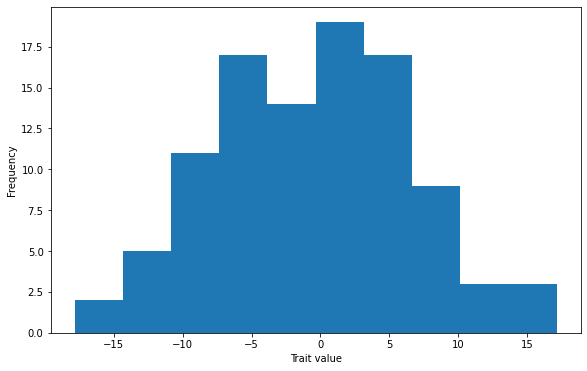

In [5]:
plt.hist(trait_vals_at_end)
plt.xlabel("Trait value")
plt.ylabel("Frequency")

With only 100 replicates, the shape of the distribution is a bit hard to interpret. Let's try 10,000 replicates:

(array([  46.,  262.,  903., 2160., 2895., 2271., 1089.,  314.,   57.,
           3.]),
 array([-24.13181668, -18.85444869, -13.5770807 ,  -8.29971271,
         -3.02234472,   2.25502327,   7.53239126,  12.80975924,
         18.08712723,  23.36449522,  28.64186321]),
 <BarContainer object of 10 artists>)

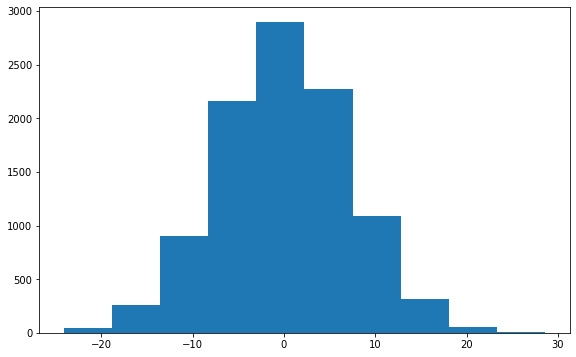

In [6]:
time = 50.0
rate = 1.0
trait_vals_at_end = []
for i in range(10000):
    trait_vals, time_points = sim_brownian_motion(
            time = time,
            rate = rate,
            time_step_size = time)
    trait_vals_at_end.append(trait_vals[-1])
plt.hist(trait_vals_at_end)

That looks normal-ish. We know from [Chapter 3](https://lukejharmon.github.io/pcm/chapter3_bmintro/) that this distribution should be normal with a mean of 0 and a variance of the rate times time ($1.0 \times 50.0$). Let's overlay the expected normal distribution onto our histogram to see if it's a good match

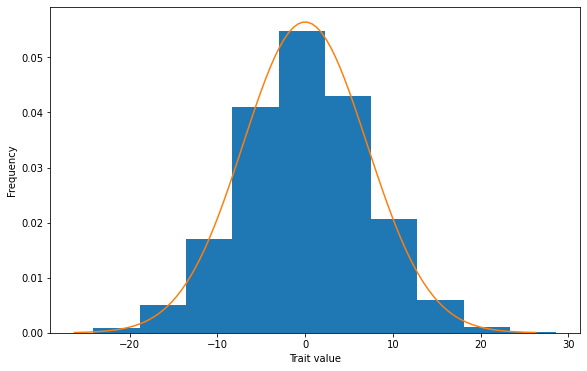

In [7]:
plt.hist(trait_vals_at_end, density = True)
plt.xlabel("Trait value")
plt.ylabel("Frequency")
expected_mean = 0.0
expected_variance = rate * time
expected_std_dev = math.sqrt(expected_variance)
expected_normal_dist = norm(expected_mean, expected_std_dev)
x_min = expected_normal_dist.ppf(0.0001)
x_max = expected_normal_dist.ppf(0.9999)
x = np.linspace(x_min, x_max, 100)
expected_density = expected_normal_dist.pdf(x)
plt.plot(x, expected_density)

That looks good!

Let's define a function to easily compare simulations under Brownian motion models with different durations, rates, or starting values. This will allow us to easily make plots similar to Figure 3.1 in
[Chapter 3](https://lukejharmon.github.io/pcm/chapter3_bmintro/).

In [8]:
def fancy_bm_sim_plots(
        times = [10, 50, 100],
        rates = [1.0, 1.0, 1.0],
        starting_values = None,
        number_of_replicates = 50,
        time_step_size = 0.1,
        rng = _RNG):
    if not starting_values:
        starting_values = [0.0] * len(times)
    assert len(times) == len(rates)
    assert len(times) == len(starting_values)
    for t in times:
        assert time_step_size <= t
    fig = plt.figure(figsize = (9.5, (4.0 * len(times))), constrained_layout = False)
    gs = fig.add_gridspec(
            nrows = len(times),
            ncols = 2,
            width_ratios = (7, 2),
            left = 0.1,
            right = 0.9,
            bottom = 0.1,
            top = 0.9,
            wspace = 0.05,
            hspace = 0.05)
    first_ax = fig.add_subplot(gs[0, 0])
    first_y_hist = fig.add_subplot(gs[0, 1], sharey = first_ax)
    for i in range(len(times)):
        ax = first_ax
        if i > 0:
            ax = fig.add_subplot(gs[i, 0], sharex = first_ax, sharey = first_ax)
        time = times[i]
        rate = rates[i]
        start_val = starting_values[i]
        vals_at_end = []
        for rep_index in range(number_of_replicates):
            trait_vals, time_points = sim_brownian_motion(
                    time = time,
                    rate = rate,
                    starting_value = start_val,
                    time_step_size = time_step_size,
                    rng = rng)
            vals_at_end.append(trait_vals[-1])
            ax.plot(time_points, trait_vals)
        ax.set_ylabel("Trait value")
        y_hist = first_y_hist
        if i > 0:
            y_hist = fig.add_subplot(gs[i, 1], sharey = ax, sharex = first_y_hist)
        y_hist.tick_params(axis = "y", labelleft = False)
        if i < len(times) - 1:
            ax.tick_params(axis = 'x', labelbottom = False)
            y_hist.tick_params(axis = 'x', labelbottom = False)
        else:
            ax.set_xlabel("Time")
            y_hist.set_xlabel("Density")
        y_hist.hist(vals_at_end, orientation = 'horizontal', density = True)
        norm_dist = norm(start_val, math.sqrt(rate * time))
        x = np.linspace(norm_dist.ppf(0.001), norm_dist.ppf(0.999), 100)
        y_hist.plot(norm_dist.pdf(x), x)
    return fig

Don't worry too much about how this plotting function works; it took a lot of Googling to figure out the correct voodoo to get it to work.

Let's test out our function by trying to reproduce Figure 3.1 in the text:

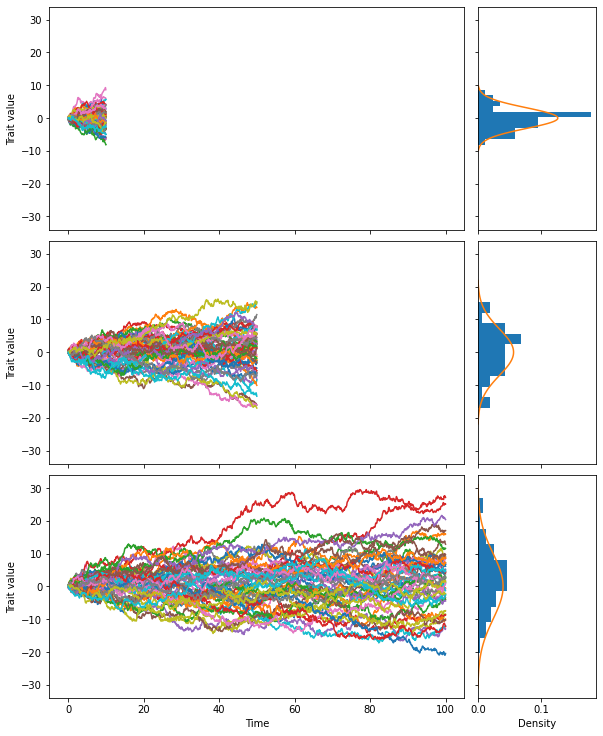

In [9]:
fig = fancy_bm_sim_plots(times = [10, 50, 100], rates = [1.0, 1.0, 1.0])

Now, let's keep the duration constant at 20, but try different rates:

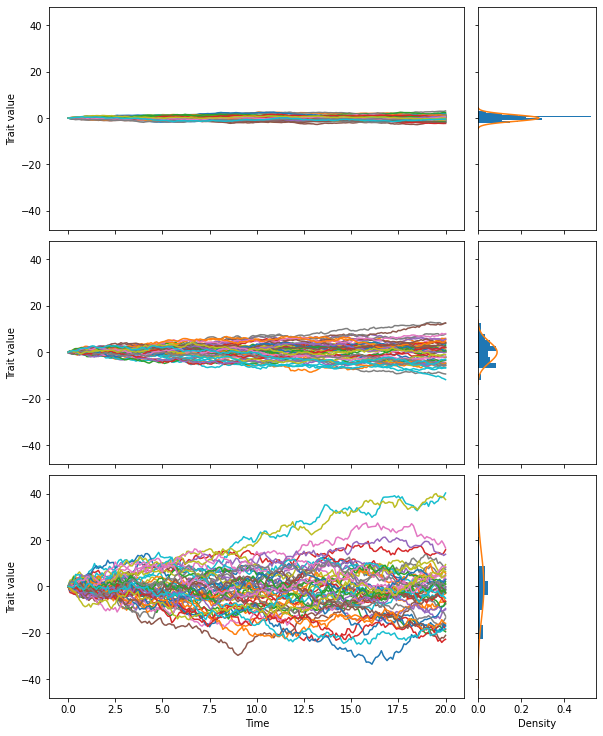

In [10]:
fig = fancy_bm_sim_plots(times = [20, 20, 20], rates = [0.1, 1.0, 10.0])

Let's try some different starting values:

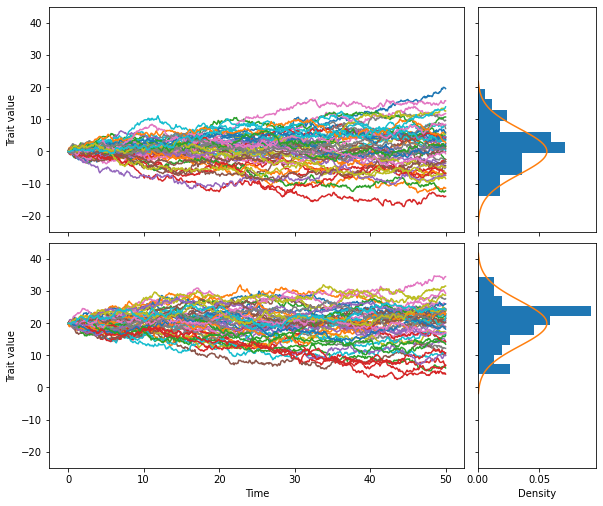

In [11]:
fig = fancy_bm_sim_plots(times = [50, 50], rates = [1, 1], starting_values = [0.0, 20.0])

Don't like the values I chose?
Try your own times, rates, and starting values!
It will help you get a feel for the behavior of Brownian motion models.